In [1]:
# import libraries
import geopandas as gpd
from datetime import datetime, timedelta
import re
import movingpandas as mpd
import numpy as np
from shapely.geometry import Point, Polygon
import pandas as pd
import matplotlib.pyplot as plt
#from pyproj import CRS
import dask.bag as db
import dask.dataframe as dd
from dask.delayed import delayed
import dask_geopandas
import osmnx as ox

In [2]:
# plot the space
# l = ox.graph_from_place("Athens", network_type="all")
place = ["Athens"]
G = ox.graph_from_place(place, retain_all=True, simplify = True, network_type='all')

In [3]:
###############################################################################
#                               4. Unpack Data                                #
###############################################################################
u = []
v = []
key = []
data = []
for uu, vv, kkey, ddata in G.edges(keys=True, data=True):
    u.append(uu)
    v.append(vv)
    key.append(kkey)
    data.append(ddata) 

In [4]:
# Lists to store colors and widths 
roadColors = []
roadWidths = []

for item in data:
    if "length" in item.keys():
        if item["length"] <= 100:
            linewidth = 0.10
            color = "#a6a6a6" 
            
        elif item["length"] > 100 and item["length"] <= 200:
            linewidth = 0.15
            color = "#676767"
            
        elif item["length"] > 200 and item["length"] <= 400:
            linewidth = 0.25
            color = "#454545"
            
        elif item["length"] > 400 and item["length"] <= 800:
            color = "#bdbdbd"
            linewidth = 0.35
        else:
            color = "#d5d5d5"
            linewidth = 0.45

        if "primary" in item["highway"]:
            linewidth = 0.5
            color = "#ffff"
    else:
        color = "#a6a6a6"
        linewidth = 0.10
            
    roadColors.append(color)
    roadWidths.append(linewidth)

In [5]:
# if it is a footway, the visualization is .25 and if it something else, the visualization is 0.5
for item in data:
    if "footway" in item["highway"]:
        color = "#ededed"
        linewidth = 0.25
    else:
        color = "#a6a6a6"
        linewidth = 0.5
        
    roadWidths.append(linewidth)

In [6]:
#Center of the map  
latitude = 37.97718
longitude = 23.73776

#Limit borders 
north = latitude + 0.002
south = latitude - 0.002
east = longitude + 0.002
west = longitude - 0.002


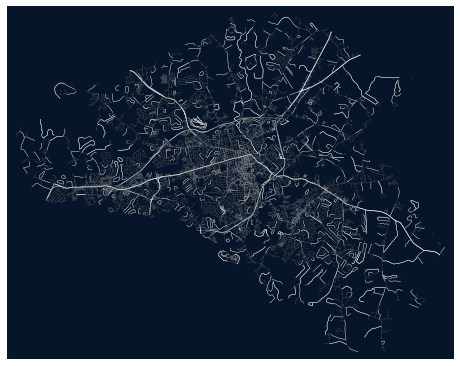

In [7]:
bgcolor = "#061529"

fig, ax = ox.plot_graph(G, node_size=0,# bbox = (north, south, east, west),
                        dpi = 300,bgcolor = bgcolor,
                        save = False, edge_color=roadColors,
                        edge_linewidth=roadWidths, edge_alpha=1, show=False, close=False)

In [9]:
# execute the dataframe for parquet
df = dd.read_parquet("20181024_d1_0830_0900-points.parquet")

In [10]:
# create the points
df = dask_geopandas.from_dask_dataframe(df)
df = df.set_geometry(
    dask_geopandas.points_from_xy(df, 'lon', 'lat')
)

In [11]:
df.head()

,ID,type,lon,lat,secs,speed,long_acc,lat_acc,geometry
0,102483011,Car,23.737688,37.977391,0,4.9178,0.0518,-0.0299,POINT (23.73769 37.97739)
1,102483011,Car,23.737688,37.977391,40,4.9207,-0.0124,-0.0354,POINT (23.73769 37.97739)
2,102483011,Car,23.737688,37.977391,80,4.9160,-0.0519,-0.0413,POINT (23.73769 37.97739)
3,102483011,Car,23.737688,37.977390,120,4.9057,-0.0914,-0.0478,POINT (23.73769 37.97739)
4,102483011,Car,23.737689,37.977390,160,4.8871,-0.1679,-0.0550,POINT (23.73769 37.97739)


In [13]:
# IDS unique
# plt.scatter(df.lon.to_dask_array(), df.lat.to_dask_array())
IDS = df.ID.unique().compute()

In [14]:
IDS

0       102483011
1       102483012
2       102483013
3       102483014
4       102483015
          ...    
917    1658367326
918    1658367327
919    1658367328
920    1658367329
921    1658367330
Name: ID, Length: 922, dtype: int32

In [17]:
# a dataframe from the first id
# fig, ax = plt.subplots(figsize=(15,15))
a = df[df.ID == 102483011].compute()

In [18]:
a

,ID,type,lon,lat,secs,speed,long_acc,lat_acc,geometry
0,102483011,Car,23.737688,37.977391,0,4.9178,0.0518,-0.0299,POINT (23.73769 37.97739)
1,102483011,Car,23.737688,37.977391,40,4.9207,-0.0124,-0.0354,POINT (23.73769 37.97739)
2,102483011,Car,23.737688,37.977391,80,4.9160,-0.0519,-0.0413,POINT (23.73769 37.97739)
3,102483011,Car,23.737688,37.977390,120,4.9057,-0.0914,-0.0478,POINT (23.73769 37.97739)
4,102483011,Car,23.737689,37.977390,160,4.8871,-0.1679,-0.0550,POINT (23.73769 37.97739)
...,...,...,...,...,...,...,...,...,...
446,102483011,Car,23.737834,37.976989,17840,41.7653,-0.0118,0.7583,POINT (23.73783 37.97699)
447,102483011,Car,23.737834,37.976985,17880,41.7633,-0.0078,0.7168,POINT (23.73783 37.97698)
448,102483011,Car,23.737834,37.976981,17920,41.7616,-0.0053,0.6745,POINT (23.73783 37.97698)
449,102483011,Car,23.737834,37.976976,17960,41.7603,-0.0011,0.6313,POINT (23.73783 37.97698)


In [20]:
ax.scatter(a.lon.to_list(), a.lat.to_list(), c = "red")

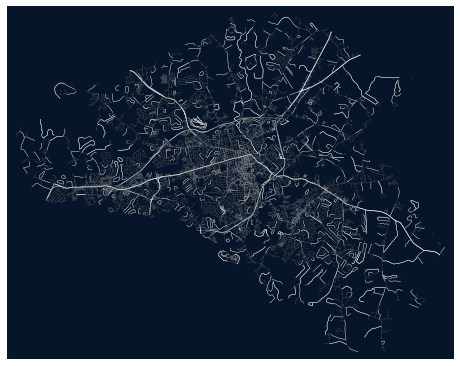

In [21]:
fig

In [25]:
print((min(a.lat) + max(a.lat))/2)
print(max(a.lat))
print(min(a.lat))

print((min(a.lon) + max(a.lon))/2)
print(max(a.lon))
print(min(a.lon))

37.9771815
37.977391
37.976972
23.737761499999998
23.737835
23.737688


In [26]:
#Center of the map  
latitude = 37.97718
longitude = 23.73776

#Limit borders 
north = latitude + 0.002
south = latitude - 0.002
east = longitude + 0.002
west = longitude - 0.002

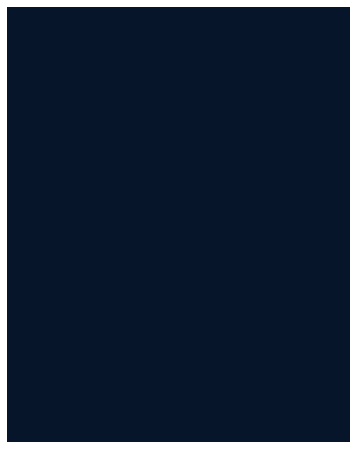

In [27]:
# plot the specific place
bgcolor = "#061529"

fig_2, ax_2 = ox.plot_graph(G, node_size=0, bbox = (north, south, east, west),
                        dpi = 300,bgcolor = bgcolor,
                        save = False, edge_color=roadColors,
                        edge_linewidth=roadWidths, edge_alpha=1, show=False, close=False)

In [28]:
ax_2.scatter(a.lon.to_list(), a.lat.to_list(), c = "red")

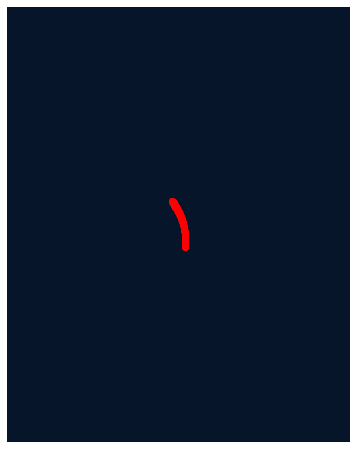

In [30]:
fig_2

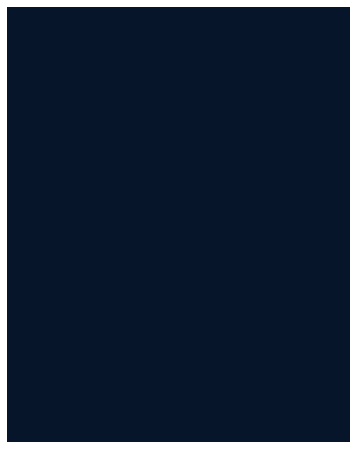

In [56]:
fig_3, ax_3 = ox.plot_graph(G, node_size=0, bbox = (north, south, east, west),
                        dpi = 300,bgcolor = bgcolor,
                        save = False, edge_color=roadColors,
                        edge_linewidth=roadWidths, edge_alpha=1, show=False, close=False);

In [38]:
df['type'].unique().compute()

0              Car
1       Motorcycle
2    MediumVehicle
3              Bus
4             Taxi
5     HeavyVehicle
Name: type, dtype: object

In [39]:
colors = {'Car' : 'blue',
         'Motorcycle': 'red',
         'MediumVehicle': 'orange',
         'Bus':'green',
         'Taxi':'yellow',
         'HeavyVehicle':'purple'}

In [59]:
for idx, id in enumerate(IDS):
  # fig, ax = plt.subplots(figsize = (15,15))

  # a = df[df.ID == id].geometry.compute()
  # cors = [ (cor.x, cor.y) for cor in a]
  # pol = Polygon(cors)
  # display(pol)
  
#     lon = df[df.ID == id].lon.compute().to_list()
#     lat = df[df.ID == id].lat.compute().to_list()
#     ax.scatter(lon, lat, c = "red")
  
    data = df[df.ID == id].compute()
    class_type = data['type'].unique()[0]
    ax_3.scatter(data.lon.to_list(), data.lat.to_list(), c = colors[class_type], s = 0.5)
    if idx == 4:
        break
  # plt.scatter(lon, lat)
  # plt.show()

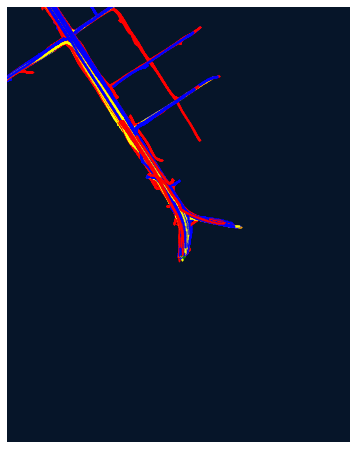

In [60]:
fig_3